In [1]:
path = "https://raw.githubusercontent.com/LunusMax/football-data/refs/heads/main/LuisSinisterra/sinisterra.csv"

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [3]:
data = pd.read_csv(path, sep=";")

In [4]:
data.head()

,Season,Age,Squad,MP,Starts,Min,90s,Gls,Ast,G+A,...,Carries,TotDist,PrgDist,PrgC.1,01/mar,CPA,Mis,Dis,Rec,PrgR.1
0,2016,16,Once Caldas,2,0,28,0.3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017,17,Once Caldas,22,10,"1,041",11.6,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2018,18,Once Caldas,17,14,"1,236",13.7,4,4,8,...,0,0,0,0,0,0,0,0,0,0
3,2018-2019,19,Feyenoord,5,0,54,0.6,0,0,0,...,33,263,149,5,5,4,0,4,35,12
4,2019-2020,20,Feyenoord,21,21,"1,616",18.0,5,4,9,...,604,3932,1708,56,25,36,50,43,713,188


In [5]:
data['Min'] = data['Min'].astype(str).str.replace(',', '').astype(int)
data

,Season,Age,Squad,MP,Starts,Min,90s,Gls,Ast,G+A,...,Carries,TotDist,PrgDist,PrgC.1,01/mar,CPA,Mis,Dis,Rec,PrgR.1
0,2016,16,Once Caldas,2,0,28,0.3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017,17,Once Caldas,22,10,1041,11.6,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2018,18,Once Caldas,17,14,1236,13.7,4,4,8,...,0,0,0,0,0,0,0,0,0,0
3,2018-2019,19,Feyenoord,5,0,54,0.6,0,0,0,...,33,263,149,5,5,4,0,4,35,12
4,2019-2020,20,Feyenoord,21,21,1616,18.0,5,4,9,...,604,3932,1708,56,25,36,50,43,713,188
5,2020-2021,21,Feyenoord,20,13,1207,13.4,3,5,8,...,480,2945,1225,41,27,22,44,28,550,127
6,2021-2022,22,Feyenoord,30,29,2405,26.7,12,7,19,...,1082,6998,3446,129,68,67,81,45,1259,313
7,2022-2023,23,Leeds United,19,13,867,9.6,5,0,5,...,281,1740,931,30,17,8,16,23,341,84
8,2023-2024,24,Leeds United,2,2,174,1.9,1,0,1,...,79,378,209,5,2,4,5,6,106,15
9,2023-2024,24,Bournemouth,20,7,699,7.8,2,2,4,...,267,2098,1195,51,20,35,24,10,309,85


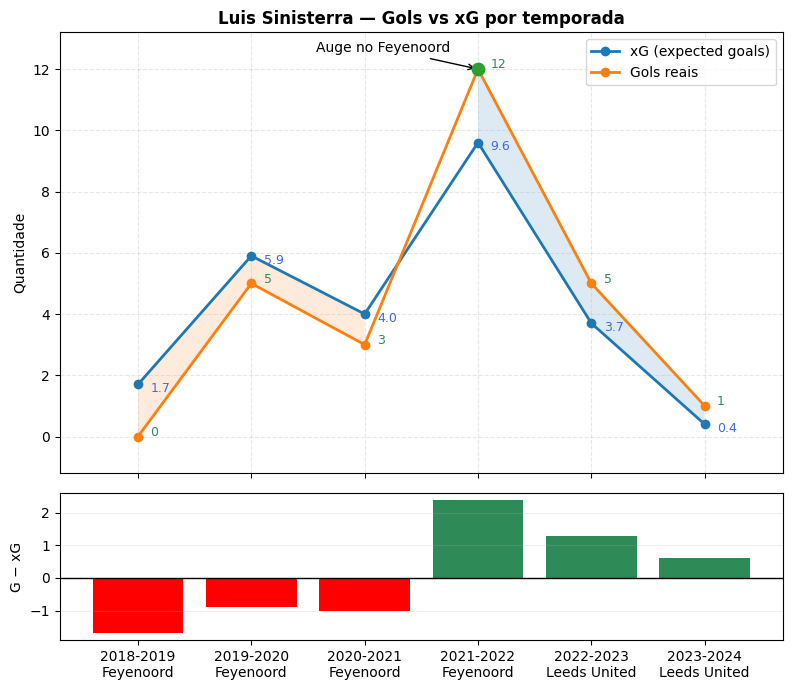

In [6]:
# Limpeza numérica básica
data["Gls"] = pd.to_numeric(data["Gls"], errors="coerce")
data["xG"]  = pd.to_numeric(data["xG"],  errors="coerce")
data["Season"] = data["Season"].astype(str)

# Filtrar só 2018-2019 em diante
keep_seasons = ["2018-2019","2019-2020","2020-2021","2021-2022","2022-2023","2023-2024"]
df_plot = (data.dropna(subset=["Gls","xG"])
              .loc[lambda d: d["Season"].isin(keep_seasons),
                   ["Season","Squad","Gls","xG"]]
              .drop_duplicates(subset=["Season"])
              .sort_values("Season")
              .reset_index(drop=True))

# Eixo numérico + rótulos com clube
x = np.arange(len(df_plot))
season_labels = [f"{s}\n{club}" for s, club in zip(df_plot["Season"], df_plot["Squad"])]

# Figura com 2 painéis: linhas + eficiência (G-xG)
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8,7),
    gridspec_kw={"height_ratios":[3,1]},
    sharex=True
)

# ---------- Topo: xG vs Gols ----------
y_xg  = df_plot["xG"].to_numpy()
y_gls = df_plot["Gls"].to_numpy()

ax1.plot(x, y_xg,  marker="o", linewidth=2, label="xG (expected goals)")
ax1.plot(x, y_gls, marker="o", linewidth=2, label="Gols reais")

# Preenchimento da área (verde = acima do esperado; vermelho = abaixo)
ax1.fill_between(x, y_gls, y_xg, where=(y_gls >= y_xg), alpha=0.15)
ax1.fill_between(x, y_gls, y_xg, where=(y_gls <  y_xg), alpha=0.15)

"""
# Rótulos nos pontos: deslocamento em pontos; último vai pra dentro (esquerda)
for i, (xi, gx, gl) in enumerate(zip(x, y_xg, y_gls)):
    if i == len(x)-1:
        off, ha = (-9, -3), "right"
    else:
        off, ha = (9, -3), "left"
    ax1.annotate(f"{gx:.1f}", (xi, gx), xytext=off, textcoords="offset points",
                 ha=ha, va="center", fontsize=9)
    ax1.annotate(f"{int(gl)}", (xi, gl), xytext=off, textcoords="offset points",
                 ha=ha, va="center", fontsize=9)
"""
# Rótulos nos pontos: todos à direita
for i, (xi, gx, gl) in enumerate(zip(x, y_xg, y_gls)):
    ax1.annotate(f"{gx:.1f}", (xi, gx), xytext=(9, -3), textcoords="offset points",
                 ha="left", va="center", fontsize=9, color="royalblue")
    ax1.annotate(f"{int(gl)}", (xi, gl), xytext=(9, 3), textcoords="offset points",
                 ha="left", va="center", fontsize=9, color="seagreen")



# Destaque do pico de gols
i_peak = int(np.argmax(y_gls))
ax1.scatter(x[i_peak], y_gls[i_peak], s=80, zorder=5)

ax1.annotate("Auge no Feyenoord",
             xy=(x[i_peak], y_gls[i_peak]),
             xytext=(-20, 15), textcoords="offset points",   # desloca para esquerda e um pouco pra cima
             ha="right", va="center",
             arrowprops=dict(arrowstyle="->", lw=1))


ax1.set_title("Luis Sinisterra — Gols vs xG por temporada", fontweight="bold")
ax1.set_ylabel("Quantidade")
ax1.grid(alpha=0.3, linestyle="--")
ax1.legend()
ax1.margins(x=0.08, y=0.10)  # garante espaço pros rótulos nas bordas

# ---------- Base: eficiência (Gols − xG) ----------
diff = y_gls - y_xg
colors = ["seagreen" if v >= 0 else "red" for v in diff]  # verde p/ positivo, vermelho p/ negativo

ax2.bar(x, diff, color=colors)
ax2.axhline(0, lw=1, color="black")
ax2.set_ylabel("G − xG")
ax2.grid(alpha=0.2, axis="y")

# Rótulos do eixo X com temporada + clube
ax2.set_xticks(x, season_labels, rotation=0)

fig.tight_layout()
plt.show()

In [7]:
data.columns

Index(['Season', 'Age', 'Squad', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast',
       'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG',
       'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'Gls.1', 'Ast.1', 'G+A.1', 'G-PK.1',
       'G+A-PK', 'xG.1', 'xAG.1', 'xG+xAG', 'npxG.1', 'npxG+xAG.1', 'Sh',
       'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK.1',
       'PKatt.1', 'xG.2', 'npxG.2', 'npxG/Sh', 'G-xG', 'np:G-xG', 'Touches',
       'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Live', 'Att',
       'Succ', 'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist',
       'PrgC.1', '01/mar', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR.1'],
      dtype='object')

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Preparação dos dados
df = data.copy()
df["Season"] = df["Season"].astype(str)

# Conversões robustas
num_cols = ["90s","Att","Succ","Succ%","Carries","PrgC.1","PrgDist"]
for c in num_cols:
    df[c] = (df[c].astype(str)
                  .str.replace(",","", regex=False)
                  .str.replace("—","", regex=False)
                  .str.replace("%","", regex=False)
                  .str.strip()
                  .replace({"": np.nan})
                  .astype(float))

# Filtro das temporadas relevantes
keep = ["2019-2020","2020-2021","2021-2022","2022-2023","2023-2024"]
df = (df[df["Season"].isin(keep)]
      .sort_values("Season")
      .reset_index(drop=True))

# Dataset de dribles
dr = df[["Season","Squad","90s","Att","Succ","Succ%","Carries","PrgC.1","PrgDist"]].rename(
    columns={"Att":"Drib_Att","Succ":"Drib_Succ","Succ%":"Drib_SuccPct",
             "PrgC.1":"Prog_Carries"}
)

# Se faltar % sucesso, calcula
if dr["Drib_SuccPct"].isna().all() and not dr["Drib_Att"].isna().all():
    dr["Drib_SuccPct"] = 100*dr["Drib_Succ"]/dr["Drib_Att"].replace(0,np.nan)

# Per 90
if dr["90s"].notna().any():
    dr["Drib_Att_per90"] = dr["Drib_Att"]/dr["90s"]
    dr["Drib_Succ_per90"] = dr["Drib_Succ"]/dr["90s"]

labels = [f"{s}\n{club}" for s, club in zip(dr["Season"], dr["Squad"])]
x = np.arange(len(dr))

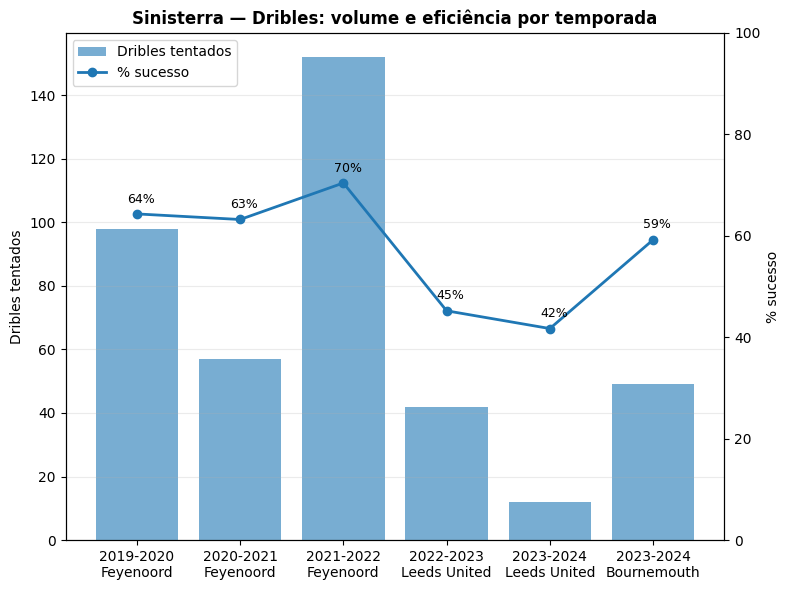

In [9]:
fig, ax1 = plt.subplots(figsize=(8,6))

# Barras = tentativas de drible
ax1.bar(x, dr["Drib_Att"], alpha=0.6, label="Dribles tentados")
ax1.set_ylabel("Dribles tentados")
ax1.set_xticks(x, labels)
ax1.grid(axis="y", alpha=0.25)

# Linha = % sucesso (eixo secundário)
ax2 = ax1.twinx()
ax2.plot(x, dr["Drib_SuccPct"], marker="o", linewidth=2, label="% sucesso")
ax2.set_ylabel("% sucesso")
ax2.set_ylim(0, 100)

# Rótulos acima dos pontos
for xi, y in zip(x, dr["Drib_SuccPct"]):
    ax2.annotate(f"{y:.0f}%", (xi, y),
                 xytext=(3, 6), textcoords="offset points",  # desloca só pra cima
                 ha="center", va="bottom", fontsize=9)

# Legenda combinada
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper left")

plt.title("Sinisterra — Dribles: volume e eficiência por temporada", fontweight="bold")
plt.tight_layout()
plt.show()


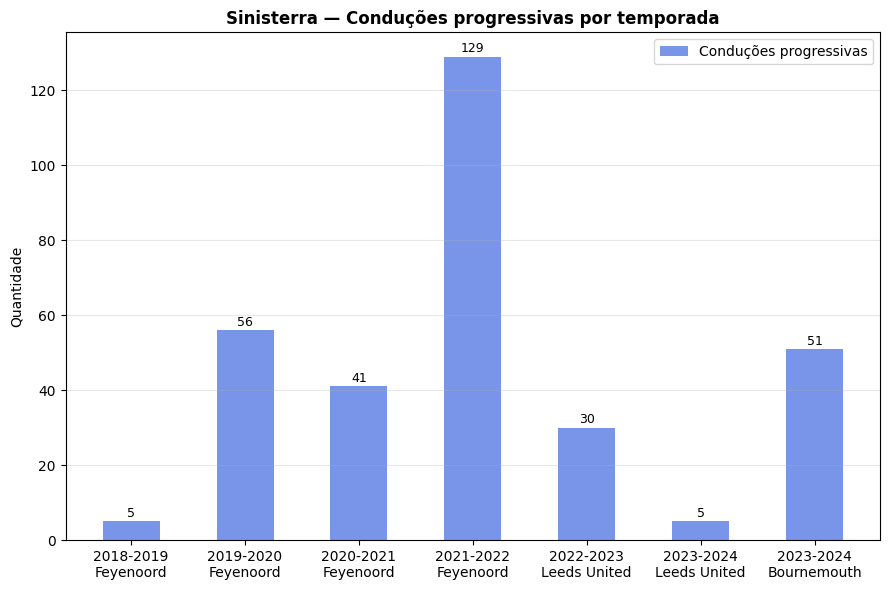

In [10]:
# Garantir numéricos
data["PrgC.1"] = (data["PrgC.1"].astype(str)
                                .str.replace(",", "", regex=False)
                                .str.replace("—", "", regex=False)
                                .replace("", np.nan)
                                .astype(float))

# Filtro temporadas relevantes
keep = ["2018-2019","2019-2020","2020-2021","2021-2022","2022-2023","2023-2024"]
df_carries = (data[data["Season"].astype(str).isin(keep)]
              .sort_values("Season")
              .reset_index(drop=True))

# Labels com temporada + clube
labels = [f"{s}\n{club}" for s, club in zip(df_carries["Season"], df_carries["Squad"])]
x = np.arange(len(df_carries))

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(x, df_carries["PrgC.1"], width=0.5, label="Conduções progressivas", alpha=0.7, color="royalblue")

# Rótulos em cima das barras
for xi, pc in enumerate(df_carries["PrgC.1"]):
    ax.annotate(f"{int(pc)}", (xi, pc), xytext=(0,3), textcoords="offset points",
                ha="center", fontsize=9)

ax.set_xticks(x, labels)
ax.set_ylabel("Quantidade")
ax.set_title("Sinisterra — Conduções progressivas por temporada", fontweight="bold")
ax.grid(axis="y", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


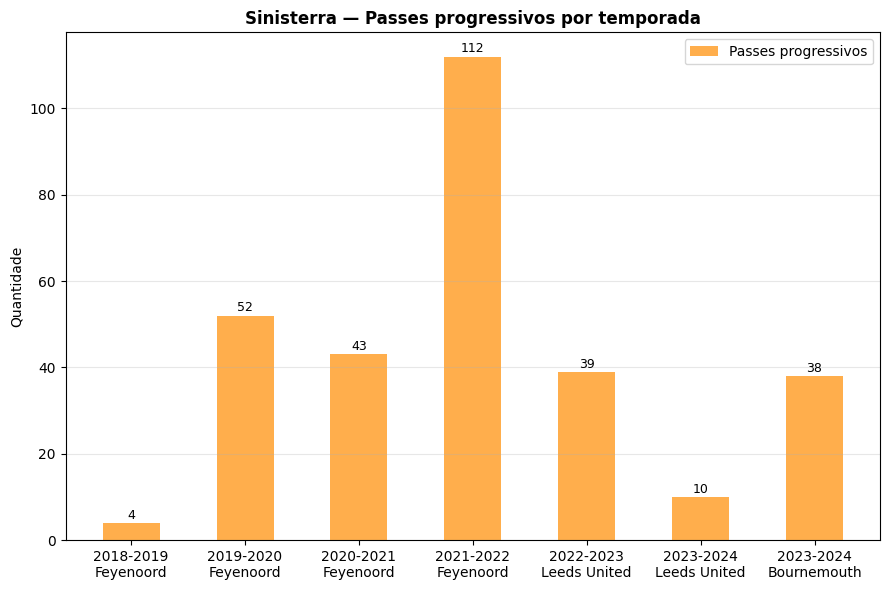

In [11]:
# Garantir numéricos
data["PrgP"] = (data["PrgP"].astype(str)
                           .str.replace(",", "", regex=False)
                           .str.replace("—", "", regex=False)
                           .replace("", np.nan)
                           .astype(float))

# Filtro temporadas relevantes
keep = ["2018-2019","2019-2020","2020-2021","2021-2022","2022-2023","2023-2024"]
df_passes = (data[data["Season"].astype(str).isin(keep)]
             .sort_values("Season")
             .reset_index(drop=True))

# Labels com temporada + clube
labels = [f"{s}\n{club}" for s, club in zip(df_passes["Season"], df_passes["Squad"])]
x = np.arange(len(df_passes))

# --- Gráfico (mesma formatação, cor diferente) ---
fig, ax = plt.subplots(figsize=(9,6))
ax.bar(x, df_passes["PrgP"], width=0.5, label="Passes progressivos", alpha=0.7, color="darkorange")

# Rótulos em cima das barras
for xi, v in enumerate(df_passes["PrgP"]):
    ax.annotate(f"{int(v)}", (xi, v), xytext=(0,3), textcoords="offset points",
                ha="center", fontsize=9)

ax.set_xticks(x, labels)
ax.set_ylabel("Quantidade")
ax.set_title("Sinisterra — Passes progressivos por temporada", fontweight="bold")
ax.grid(axis="y", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
